In [56]:
!pip install MechanicalSoup
!pip install beautifulsoup4

In [57]:
import mechanicalsoup
import requests
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import math
import random

import re
import io

import matplotlib 
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets
from ipywidgets import fixed
# %matplotlib widget
# functions contained in this ipynb:
'''
get_data(planet, observer,observatory,city, start, end, interval_mode, step_size, angular)
addnoise(data,mu,sigma,typ="gaussian")
sparsify(data,percent)
visibledata(planettarget, planetob,start, end, interval_mode, step_size,Rsun=1/215)
c2s(cor)
s2c(cor)
outtxt(cor,outfile)
'''

'\nget_data(planet, observer,observatory,city, start, end, interval_mode, step_size, angular)\naddnoise(data,mu,sigma,typ="gaussian")\nsparsify(data,percent)\nvisibledata(planettarget, planetob,start, end, interval_mode, step_size,Rsun=1/215)\nc2s(cor)\ns2c(cor)\nouttxt(cor,outfile)\n'

In [58]:
#this function is an application program interface(API) to online resources of HORIZON system and get the ephemeris data of planets in the solar system
def get_data(planet, observer,observatory,city, start, end, interval_mode, step_size, angular):
#     print("Calling get_data function....")
#     print("this function is an application program interface(API) to online resources of HORIZON system and get the ephemeris data of planets in the solar system, the units are au and au/d")
    planet_to_code = {"sun":"MB:10", "mercury":"MB:199","venus":"MB:299","earth":"MB:399","mars":"MB:499","jupiter":"MB:599",
                  "saturn":"MB:699","uranus":"MB:799","neptune":"MB:899","pluto":"MB:999"}
    observer_to_code={"sun":"@sun","earth":"500"}
    browser = mechanicalsoup.StatefulBrowser()
    url = "https://ssd.jpl.nasa.gov/horizons.cgi"
    browser.open(url)
    browser.follow_link("i?s_type=1")
    browser.select_form()
    if angular and (observer.lower()=="sun" or observer.lower()=="earth"):
        print("error, want angular coordinates but do not specify any observatory or city...")
        exit(1)
    if angular:
        browser["table_type"] = "OBSERVER"
    else:
        browser["table_type"] = "VECTORS"
    response = browser.submit_selected(btnName="set_table_type")
    browser.follow_link("i?s_target=1")
    browser.select_form()
    browser["mb_list"] = "planet"
    response = browser.submit_selected(btnName="show_mb_list")
    browser.select_form()
    browser["body"] = planet_to_code[planet.lower()]
    response = browser.submit_selected(btnName="select_body")
    browser.follow_link("i?s_loc=1")
    if observer.lower()=="sun" or observer.lower()=="earth":
        browser.select_form(nr=0)
        browser["l_str"]=observer_to_code[observer.lower()]
        browser.submit_selected(btnName="s_lookup")
    elif observer.lower()=="observatory":
        browser.select_form(nr=1)
        browser["l_list"]="obs"
        response = browser.submit_selected(btnName="s_list")
        browser.select_form()
        browser["loc_list"] = "399;{};{};".format(observatory[0],observatory[1])
        response = browser.submit_selected()
    elif observer.lower()=="city":
        browser.select_form(nr=1)
        browser["l_list"]="all"
        response = browser.submit_selected(btnName="s_list")
        browser.select_form()
        if "," in city:
            browser["loc_list"] = "399;;{};{}".format(city.split(",")[0].strip(),city.split(",")[1].strip())
        else:
            browser["loc_list"] = "399;;{};".format(city.strip())
        response = browser.submit_selected()
    browser.follow_link("i?s_time=1")
    browser.select_form()
    browser["start_time"] = start
    browser["stop_time"] = end
    browser["interval_mode"] = interval_mode
    browser["step_size"] = step_size
    response = browser.submit_selected(btnName="set_time_span")

    if angular:
        browser.follow_link("i?s_tset=1")
        browser.select_form()
        response = browser.submit_selected(btnName="preset_q_table_d")
        form = browser.select_form()
        browser["oq_4"]=1
        browser["csv_format"]="YES"
        #browser.get_current_form().print_summary()
        submit = browser.get_current_page().find(name='set_table')
        form.choose_submit(submit)
        browser.submit_selected()
    else:
        browser.follow_link("i?s_tset=1")
        browser.select_form()
        form = browser.select_form()
        browser["csv_format"]="YES"
        #browser.get_current_form().print_summary()
        submit = browser.get_current_page().find(name='set_table')
        form.choose_submit(submit)
        browser.submit_selected()
        
        
    browser.select_form()
    response = browser.submit_selected()
    s = response.text

    if angular:
        # split the string at the following regex
        # group 0 is the whole pattern, 1 is the first (), which is the header,
        # group 2 is the second (), which is the data table
        pattern = "Table format.*?:.*?Comma Separated Values.*?\*\n(.*?\n).*?\$\$SOE\n(.*?)\$\$EOE"
        #print(s)
        table_string = re.search(pattern,s,re.DOTALL)
        if table_string:
            data_string = table_string.group(1)+table_string.group(2)
            data = io.StringIO(data_string)
            df = pd.read_csv(data,sep=',')
        else:
#             print('Error: could not find a data table corresponding to observation table, check your input and make sure the format is right....')
            exit(1)
        # strip the white space from the headers
        df.rename(columns=lambda x: x.strip(), inplace=True)
#         df.rename(columns={ df.columns[1]: "is_sun", 
#                            'Date__(UT)__HR:MN':'time',
#                            'Azi_(a-app)':'az',
#                            'Elev_(a-app)':'el'}, inplace = True)
#         print(df)
        df.rename(columns={ df.columns[1]: "is_sun", }, inplace = True)
        dates = df['Date__(UT)__HR:MN'].to_numpy()
        az = df['Azi_(a-app)'].to_numpy()
        el = df['Elev_(a-app)'].to_numpy()
        is_sun = df['is_sun'].to_numpy()
#         print("data retrieved successfully...")
        return dates, az, el, is_sun
#         return df[['time','is_sun','az','el']].copy()
    
    else:
        # split the string at the following regex
        # group 0 is the whole pattern, 1 is the first (), which is the header,
        # group 2 is the second (), which is the data table
        pattern = "Reference frame.*?\*\n(.*?\n).*?\$\$SOE\n(.*?)\$\$EOE"
        #print(s)
        table_string = re.search(pattern,s,re.DOTALL)
        if table_string:
            data_string = table_string.group(1)+table_string.group(2)
            data = io.StringIO(data_string)
            df = pd.read_csv(data,sep=',')
        else:
#             print('Error: could not find a data table corresponding to observation table, check your input and make sure the format is right....')
            exit(1)
        # strip the white space from the headers
        df.rename(columns=lambda x: x.strip(), inplace=True)
        #df.rename(columns={ df.columns[1]: "is_sun" }, inplace = True)
        #print(df)
        date = df["Calendar Date (TDB)"].to_numpy()
        cor = np.vstack((df.X.to_numpy(),df.Y.to_numpy(),df.Z.to_numpy())).T
        vel = np.vstack((df.VX.to_numpy(),df.VY.to_numpy(),df.VZ.to_numpy())).T
        #is_sun = df['is_sun']
#         print("data retrieved successfully...")
        return date,cor,vel

#possible type of noise are gaussian/uniform random noise
def addnoise(data,mu=0,sigma=0.01,typ="gaussian"):
#     print("adding ",typ," noise to data......")
#     print("mu=",mu," and sigma=",sigma)
    ldata=np.copy(data)
    shape=np.shape(ldata)
    ldata=ldata.flatten()
    size=len(ldata)
    if typ=="gaussian":
        ldata+=np.random.normal(mu,sigma,size=size)
    elif typ=="uniform":        
        ldata+=sigma*(np.random.rand(size)-0.5+mu)
    else:
        print("invalid type of noise!")
        print("available types of noise are gaussian or uniform.")
        exit(1)
    return ldata.reshape(shape)

#randomly delete percentage of data assigned by percent
#you may want to do this to sparsify the data due random conditions like weathers, people in charge of observing ask for a day off or so.
def sparsify(data,percent):
    n=len(data)
    ndrawn=int(n*(1-percent))
    print("sparsify ",n,"data into ",n-ndrawn," data...")
    dellist=random.sample(range(n),ndrawn)
    return np.delete(data,dellist,axis=0)

#given cartesian coodinates, convert it to spherical coordinates
def c2s(cor):
    x=cor[:,0]
    y=cor[:,1]
    z=cor[:,2]
    R=np.sqrt(x**2+y**2+z**2)
    theta=np.arccos(z/R)
    phi=np.arctan2(y,x)
    cornew=np.zeros((np.shape(cor)))
    cornew[:,0]=R
    cornew[:,1]=theta
    cornew[:,2]=phi
    return cornew
#given spherical coodinates, convert it to cartesian coordinates, unit au
def s2c(cor):
    r=cor[:,0]
    theta=cor[:,1]
    phi=cor[:,2]
    x=r*np.cos(theta)
    y=r*np.sin(theta)*np.sin(phi)
    z=r*np.sin(theta)*np.cos(phi)
    cornew[:,0]=x
    cornew[:,1]=y
    cornew[:,2]=z
    return cornew
#save the data in a file
def outtxt(cor,outfile):
    print("writing output to",outfile)
    outfil=open(outfile,"w")
    for i in range(len(cor)):
        outfil.write("{:>24.9E}{:>24.9E}{:>24.9E}\n".format(cor[i,0],cor[i,1],cor[i,2]))
    outfil.close()
    print("done...")
def visibledata(planettarget, planetob,start, end, interval_mode, step_size,Rsun=1/215):
    print("visibledata function: get rid of a data point when planettarget is ahead or behind the sun as observed on planetob so that it shouldn't be visible.")
    date,corta,velta = get_data(planettarget,"sun",observatory,city, start, end, interval_mode, step_size)
    date,corob,velob = get_data(planetob,"sun",observatory,city, start, end, interval_mode, step_size)
    d=np.linalg.norm(np.cross(corta-corob,corob),axis=1)/np.linalg.norm(corta-corob,axis=1)
    idx=np.argwhere(d>Rsun)
    idx=idx.reshape(len(d))
    newdate=[date[i] for i in range(len(date)) if d[i]>Rsun]
    return newdate,corta[idx],velta[idx]   
#get the azimuth and elevation of the sun
def get_data_sun(observer,observatory,city, start, end, interval_mode, step_size):
    return get_data("sun", observer, observatory, city, start, end, interval_mode, step_size, True)

def is_sun_2_vis(is_sun,thresh):
    '''
    Function to determine whether the is_sun designation tells us that we can see the planet.
    
    Input:
        is_sun: numpy array of strings
            Holds arrays containing a string with a single space ' ', 'A', 'N', 'C', or '*'. Meanings below
        thresh:  string
            Sets the is_sun value(s) that constitute the object being visible. This is mean to reflect the fact that
            most celestial bodies are not visible to the naked eye during the day
            Designations below:
            ' ' (string of one space): Night time. Probably not useful, as this will set everything to not visible
            'A' astronautical sunrise/dusk sun is well below horizon, but is lighting up the sky somewhat
                setting this as threshold means any setting greater than or equal this (all that follow) will
                rebder the object invisible
            'N' nautical sunrise/dusk = sun is still below the horizon, but sky is lighting up
            'C' civil sunrise = sun is breaching over the horizon
            '*' daytime using this setting means planets are visisble until daytime
    '''
    if thresh == ' ':
        is_visible = np.zeros(is_sun.shape,dtype=bool)
    elif thresh == 'A':
        is_visible = ~np.isin(is_sun,['A','N','C','*'])
    elif thresh == 'N':
        is_visible = ~np.isin(is_sun,['N','C','*'])
    elif thresh == 'C':
        is_visible = ~np.isin(is_sun,['C','*'])
    else:
        is_visible = ~np.isin(is_sun,['*'])
    
    return is_visible
        
        

In [59]:
def convert_2_datetime(strings):
    month_dict = {
        'Jan':'01',
        'Feb':'02',
        'Mar':'03',
        'Apr':'04',
        'May':'05',
        'Jun':'06',
        'Jul':'07',
        'Aug':'08',
        'Sep':'09',
        'Oct':'10',
        'Nov':'11',
        'Dec':'12'
    }
    strings = np.char.replace(strings,'b','-',count=1)
    strings = np.char.replace(strings,' ','T')
    for key in month_dict.keys():
        strings = np.char.replace(strings,key,month_dict[key])
    
    #dates = np.datetime64(strings)
    dates = np.array(strings, dtype='datetime64[h]')
    
    return dates
        
        
        
def get_venus(start, end, step_size = 1, interval_mode = "h",offset=0):
    #time interval mode, available options are: d(day),h(hour),m(minute),Y(year),MO(month)
    
    #time interval, in unit of interval_mode, currently set as 50 days
    #     step_size = 1

    date,az,el,is_sun = get_data("Venus","city",["K03", "Observatori AAS Montsec"],"Belize City", start, end, interval_mode, step_size, angular=True)
    #get the azimuth and elevation of the sun
#     date_sun, az_sun, el_sun, is_sun_sun = get_data_sun(observer,observatory,city, start, end, interval_mode, step_size)
    #plot out the trajectory of Venus and Sun on the sky viewed on Earth
    #elevation should be bigger than zero --- above the horizon
#     import pdb; pdb.set_trace()
    az_n = addnoise(az)
    el_n = addnoise(el)
    flag = el>0
    #shouldn't be blinded by the sun light
    flag_sun = is_sun_2_vis(is_sun,'*')
    #print(is_sun)
    #print(flag_sun)
    #get rid of the data under the horizon
    az_good = az[flag]
    el_good = el[flag]
    az_good_2 = az[flag & flag_sun]
    el_good_2 = el[flag & flag_sun]
    az_good_n = az_n[flag]
    el_good_n = el_n[flag]
    az_good_2_n = az_n[flag & flag_sun]
    el_good_2_n = el_n[flag & flag_sun]
    time = np.arange(offset, step_size*len(az)+offset, step_size)
    #date = date.astype(str)
    #time = convert_2_datetime(date)
    #if offset is None:
    #    time = time-time[0]
    time_good = time[flag]
    time_good_2 = time[flag & flag_sun]
    return az,el,time,az_good,el_good,time_good,az_good_2,el_good_2,time_good_2,az_n,el_n,az_good_n,el_good_n,az_good_2_n,el_good_2_n
    

In [60]:
az,el,time,az_good,el_good,time_good,az_good_2,el_good_2,time_good_2,az_n,el_n,az_good_n,el_good_n,az_good_2_n,el_good_2_n = get_venus("AD 925-Oct-13","AD 945-Oct-14", 2)


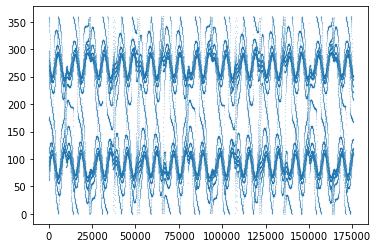

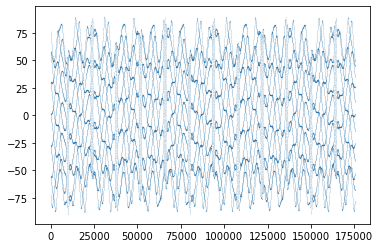

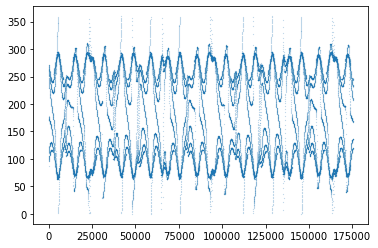

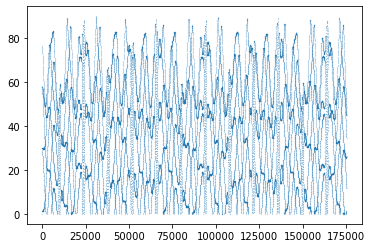

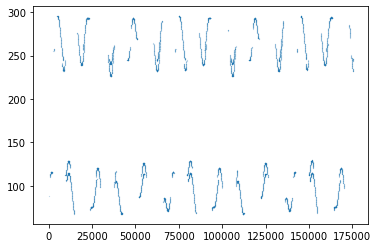

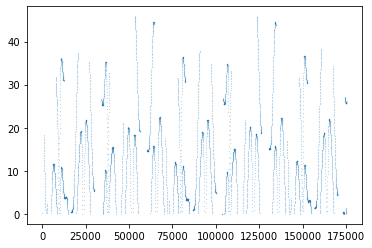

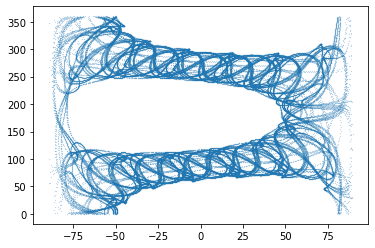

In [61]:
plt.scatter(time,az,s=0.01)
plt.show()
plt.scatter(time,el,s=0.001)
plt.show()
plt.scatter(time_good,az_good,s=0.01)
plt.show()
plt.scatter(time_good,el_good,s=0.01)
plt.show()
plt.scatter(time_good_2,az_good_2,s=0.01)
plt.show()
plt.scatter(time_good_2,el_good_2,s=0.01)
plt.show()
plt.scatter(el,az,s=0.01)
plt.show()


In [62]:
def featurize_fourier(x, d, normalize = False):
    assert (d-1) % 2 == 0, "d must be odd"
    max_r = int((d-1)/2)
    n = len(x)
    A = np.zeros((n, d))
    A[:,0] = 1
    L = max(x)-min(x)
    for d_ in range(1,max_r+1):
        A[:,2*(d_-1)+1] =  np.sin(d_*x*2*np.pi/(L))
        A[:,2*(d_-1)+2] =  np.cos(d_*x*2*np.pi/(L))
    
    if normalize:
        A[:,0] *= (1/np.sqrt(2))
        A *= np.sqrt(2)
        
#     import pdb;pdb.set_trace()
    return A

def plot_fourier_features(x_type,d): 
    n = 128  
    d_max = 21
    np.random.seed(7)
    x_true = generate_x(x_type = 'grid', n=1000)
    x_train = generate_x(x_type=x_type, n=n)
    phi_train = featurize_fourier(x_train, d_max)
    phi_true = featurize_fourier(x_true, d_max)
    
    plt.plot(x_true, phi_true[:,d], linewidth = 0.5)
    plt.scatter(x_train, phi_train[:,d], marker='o')
    plt.ylim([-1.2,1.2])
    plt.xlabel('x')
    plt.ylabel('$\phi(x)$')
    plt.show()
    
from numpy.polynomial.polynomial import polyvander
def featurize_vandermonde(x, d, normalize = False):
    A = polyvander(x, d-1)
    for d_ in range(A.shape[1]):
        if normalize:
            A[:,d_] *=  np.sqrt(2*d_+1)
    print(A.shape)
    return A

def featurize(x, d, phi_type, normalize = False):
    function_map = {'polynomial':featurize_vandermonde, 'fourier':featurize_fourier}
    return function_map[phi_type](x,d,normalize)

from sklearn.linear_model import LinearRegression
def solve_ls(phi, y):
    
    LR = LinearRegression(fit_intercept=False, normalize=False)

#     LR.fit(TODO)
#     coeffs = TODO
    LR.fit(phi, y)
    coeffs = LR.coef_
    
    loss = np.mean((y- phi@coeffs)**2)
    return coeffs, loss

from sklearn.linear_model import Ridge

def solve_ridge(phi, y, lambda_ridge=0):
    
    Rdg = Ridge(fit_intercept=False, normalize=False, alpha = lambda_ridge)

#     Rdg.fit(TODO)
#     coeffs = TODO
    Rdg.fit(phi, y)
    coeffs = Rdg.coef_

    loss = np.mean((y- phi@coeffs)**2) + np.mean(coeffs**2)
    return coeffs, loss

def get_plot_data( phi_type, d, w, n_plot = 1000,whiten_flag = True):
    indices = np.arange(0,len(time_good_2),max(1,int(len(time_good_2)/n_plot)))
    x_trains= np.array(time_good_2)[indices]
    y_trains=np.array(az_good_2)[indices]
    if whiten_flag:
        y_trains = whiten(y_trains)
#     import pdb; pdb.set_trace()
#     x_plot= generate_x(x_type = 'grid', n=n_plot)
#     y_plot_true = generate_y(x=x_plot)
    phi_plot = featurize(x_trains, d, phi_type)
    
    return x_trains, y_trains, phi_plot @ w

def whiten(y):
    y = (y-np.mean(y))/np.std(y)
    return y

def gen_and_solve(n, d, x_type, phi_type, seed = 1, awgn_std = 0, lambda_ridge = 0, whiten_flag = True):
    np.random.seed(seed)
    
#     x_train = generate_x(x_type=x_type, n=n)
    indices = np.arange(0,len(time_good_2),max(1,int(len(time_good_2)/n)))
    x_trains= np.array(time_good_2)[indices]
    y_trains=np.array(az_good_2)[indices]
    
    phi_train = featurize(x_trains, d, phi_type)
#     y_train = generate_y(x=x_train)
    
    if awgn_std != 0:
        y_trains = add_awgn_noise(y_trains, awgn_std)
        
    if whiten_flag:
        y_trains = whiten(y_trains)
        
        
    if lambda_ridge == 0:
        w, loss = solve_ls(phi_train, y_trains)

    else:
        w, loss = solve_ridge(phi_train, y_trains, lambda_ridge)


    return x_trains, y_trains, w, loss

def visualize_(x_train, y_train,  phi_type, d, w, loss, n_plot = 1000, n_fit = 1000):
    x_plot, y_plot_true, y_plot_pred = get_plot_data( phi_type, d, w, n_plot)
    plt.plot(x_plot, y_plot_true, label = 'True function')
    plt.scatter(x_train, y_train, marker='o', s=20, label = 'Training samples')
    plt.plot(x_plot, y_plot_pred, 'o-', ms=2, label = 'Learned function')

    plt.title("Train loss:" + str("{:.2e}".format(loss)))
#     plt.ylim([-1.5, 1.5])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(bbox_to_anchor = (1.03, 0.97))
    plt.show()
        
    markerlines, stemlines,  baseline = plt.stem(np.arange(d), w, 'b', 'o',  use_line_collection=True)
    plt.setp(stemlines, 'color', plt.getp(markerlines,'color'))
    plt.xlabel('feature #(k)')
    plt.ylabel('weight')
    plt.show()

def plot_true_and_predicted(n, n_plot, n_fit, x_type, phi_type, seed, awgn_std, lambda_ridge, d): 
    x_train, y_train, w, loss = gen_and_solve(n, d, x_type,  phi_type, awgn_std = awgn_std, lambda_ridge = lambda_ridge, seed = seed)
    fit_mse = visualize_(x_train, y_train,  phi_type, d, w, loss, n_plot , n_fit)
    idx_max = np.argmax(w)
    d_max = np.ceil(idx_max/2)
    period_max_power = 2*(max(x_train)-min(x_train))/d_max/24
    print('Max Power Period is {} days'.format(period_max_power))

def get_params2():
    n = 64
    n_plot = 1000
    n_fit = 10000
    x_type = 'uniform_random'
    seed = 1
    awgn_std = 0
    lambda_ridge = 0
    return n, n_plot, n_fit, x_type, seed, awgn_std, lambda_ridge

n, n_plot, n_fit, x_type, seed, awgn_std, lambda_ridge = get_params2()

slider3 = widgets.IntSlider(
    value=1,
    min=1,
    max=200,
    step=2,
    description='d:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
slider4 = widgets.IntSlider(
    value=65,
    min=65,
    max=1000,
    step=2,
    description='n:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
#lambda slider
slider5 = widgets.FloatLogSlider(
    value=10,
    base = 10,
    min=-10,
    max=10,
    step=1,
    description='$\lambda$:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1e'
)

phi_type = 'fourier'
print("{} features".format(phi_type))

interactive_plot =interactive(plot_true_and_predicted, n = slider4, n_plot = fixed(n_plot), n_fit = fixed(n_fit), 
                              x_type = fixed(x_type), phi_type = fixed(phi_type),seed = fixed(seed),
                              awgn_std= fixed(awgn_std), lambda_ridge = slider5, d = slider3)
interactive_plot

fourier features


interactive(children=(IntSlider(value=65, continuous_update=False, description='n:', max=1000, min=65, step=2)…

## Try fourier features and fourier with spiked covariance model

In [ ]:
def featurize_fourier_spiked(x, d, s, gamma):
    assert (d-1) % 2 == 0, "d must be odd"
    max_r = int((d-1)/2)
    n = len(x)
    A = np.zeros((n, d))
    A[:,0] = 1
    L = max(x)-min(x)
    
    c0 = np.sqrt(gamma*d/s)
    c1 = np.sqrt((1-gamma)*d/(d-s))
    for d_ in range(1,max_r+1):
        A[:,2*(d_-1)+1] =  np.sin(d_*x*2*np.pi/(L))
        A[:,2*(d_-1)+2] =  np.cos(d_*x*2*np.pi/(L))
        if d_<s:
            A[:,2*(d_-1)+1] *= c0
            A[:,2*(d_-1)+2] *= c0
        else:
            A[:,2*(d_-1)+1] *= c1
            A[:,2*(d_-1)+2] *= c1
            
    return A

def featurize(x, d, phi_type, s, gamma):
    function_map = {'fourier_spiked':featurize_fourier_spiked}
    return function_map[phi_type](x,d,s,gamma)

from sklearn.linear_model import LinearRegression
def solve_ls(phi, y):
    
    LR = LinearRegression(fit_intercept=False, normalize=False)

#     LR.fit(TODO)
#     coeffs = TODO
    LR.fit(phi, y)
    coeffs = LR.coef_
    
    loss = np.mean((y- phi@coeffs)**2)
    return coeffs, loss

from sklearn.linear_model import Ridge

def solve_ridge(phi, y, lambda_ridge=0):
    
    Rdg = Ridge(fit_intercept=False, normalize=False, alpha = lambda_ridge)

#     Rdg.fit(TODO)
#     coeffs = TODO
    Rdg.fit(phi, y)
    coeffs = Rdg.coef_

    loss = np.mean((y- phi@coeffs)**2) + np.mean(coeffs**2)
    return coeffs, loss

def get_plot_data( phi_type, d, w, s, gamma, n_plot = 1000,whiten_flag = True):
    indices = np.arange(0,len(time_good_2),max(1,int(len(time_good_2)/n_plot)))
    x_trains= np.array(time_good_2)[indices]
    y_trains=np.array(az_good_2)[indices]
    if whiten_flag:
        y_trains = whiten(y_trains)
#     import pdb; pdb.set_trace()
#     x_plot= generate_x(x_type = 'grid', n=n_plot)
#     y_plot_true = generate_y(x=x_plot)
    phi_plot = featurize(x_trains, d, phi_type,s,gamma)
    
    return x_trains, y_trains, phi_plot @ w

def whiten(y):
    y = (y-np.mean(y))/np.std(y)
    return y

def gen_and_solve(n, d, x_type, phi_type, s, gamma, seed = 1, awgn_std = 0, lambda_ridge = 0, whiten_flag = True):
    np.random.seed(seed)
    
#     x_train = generate_x(x_type=x_type, n=n)
    indices = np.arange(0,len(time_good_2),max(1,int(len(time_good_2)/n)))
    x_trains= np.array(time_good_2)[indices]
    y_trains=np.array(az_good_2)[indices]
    
    phi_train = featurize(x_trains, d, phi_type, s, gamma)
#     y_train = generate_y(x=x_train)
    
    if awgn_std != 0:
        y_trains = add_awgn_noise(y_trains, awgn_std)
        
    if whiten_flag:
        y_trains = whiten(y_trains)
        
        
    if lambda_ridge == 0:
        w, loss = solve_ls(phi_train, y_trains)

    else:
        w, loss = solve_ridge(phi_train, y_trains, lambda_ridge)


    return x_trains, y_trains, w, loss

def visualize_(x_train, y_train,  phi_type, d, w, loss, s, gamma, n_plot = 1000, n_fit = 1000):
    x_plot, y_plot_true, y_plot_pred = get_plot_data( phi_type, d, w, s,gamma, n_plot)
    plt.plot(x_plot, y_plot_true, label = 'True function')
    plt.scatter(x_train, y_train, marker='o', s=20, label = 'Training samples')
    plt.plot(x_plot, y_plot_pred, 'o-', ms=2, label = 'Learned function')

    plt.title("Train loss:" + str("{:.2e}".format(loss)))
#     plt.ylim([-1.5, 1.5])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(bbox_to_anchor = (1.03, 0.97))
    plt.show()
        
    markerlines, stemlines,  baseline = plt.stem(np.arange(d), w, 'b', 'o',  use_line_collection=True)
    plt.setp(stemlines, 'color', plt.getp(markerlines,'color'))
    plt.xlabel('feature #(k)')
    plt.ylabel('weight')
    plt.show()

def plot_true_and_predicted(n, n_plot, n_fit, x_type, phi_type, seed, awgn_std, lambda_ridge, d, s, gamma): 
    x_train, y_train, w, loss = gen_and_solve(n, d, x_type,  phi_type,s,gamma, awgn_std = awgn_std, lambda_ridge = lambda_ridge, seed = seed)
    fit_mse = visualize_(x_train, y_train,  phi_type, d, w, loss,s,gamma, n_plot , n_fit)
    idx_max = np.argmax(w)
    d_max = np.ceil(idx_max/2)
    period_max_power = 2*(max(x_train)-min(x_train))/d_max/24
    print('Max Power Period is {} days'.format(period_max_power))

def get_params2():
    n = 64
    n_plot = 1000
    n_fit = 10000
    x_type = 'uniform_random'
    seed = 1
    awgn_std = 0
    lambda_ridge = 0
    return n, n_plot, n_fit, x_type, seed, awgn_std, lambda_ridge

n, n_plot, n_fit, x_type, seed, awgn_std, lambda_ridge = get_params2()

slider3 = widgets.IntSlider(
    value=1,
    min=1,
    max=10000,
    step=2,
    description='d:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
slider4 = widgets.IntSlider(
    value=65,
    min=65,
    max=1000,
    step=2,
    description='n:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
#lambda slider
slider5 = widgets.FloatLogSlider(
    value=10,
    base = 10,
    min=-10,
    max=10,
    step=1,
    description='$\lambda$:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1e'
)
#s slider
slider6 = widgets.IntSlider(
    value=1,
    min=1,
    max=1000,
    step=1,
    description='s:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
#gamma slider
slider7 = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1,
    step=0.1,
    description='$\gamma$:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)

phi_type = 'fourier_spiked'
print("{} features".format(phi_type))

interactive_plot =interactive(plot_true_and_predicted, n = slider4, n_plot = fixed(n_plot), n_fit = fixed(n_fit), 
                              x_type = fixed(x_type), phi_type = fixed(phi_type),seed = fixed(seed),
                              awgn_std= fixed(awgn_std), lambda_ridge = 0, d = slider3, s = slider6, gamma=slider7)
interactive_plot

## Build and train a model, then test

In [281]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

def sparsify(x,y,percent):
    rand_idx = np.random.choice(len(y),int(np.round(len(y)*percent)),replace=False)
    return x[rand_idx],y[rand_idx]

def add_noise(y,sigma):
    y_noise = y+sigma*np.random.randn(len(y))
    y_noise[y_noise<0] += 360
    y_noise[y_noise>=360] = y_noise[y_noise>360]%360
    
    return(y_noise)
    
def whiten(y):
    y = (y-np.mean(y))/np.std(y)
    return y


def featurize_fourier_spiked(x, d, L, s, gamma):
    assert (d-1) % 2 == 0, "d must be odd"
    max_r = int((d-1)/2)
    n = len(x)
    A = np.zeros((n, d))
    A[:,0] = 1
    L = max(x)-min(x)
    
    c0 = np.sqrt(gamma*d/s)
    c1 = np.sqrt((1-gamma)*d/(d-s))
    for d_ in range(1,max_r+1):
        A[:,2*(d_-1)+1] =  np.sin(d_*x*2*np.pi/(L))
        A[:,2*(d_-1)+2] =  np.cos(d_*x*2*np.pi/(L))
        if d_<s:
            A[:,2*(d_-1)+1] *= c0
            A[:,2*(d_-1)+2] *= c0
        else:
            A[:,2*(d_-1)+1] *= c1
            A[:,2*(d_-1)+2] *= c1
            
    return A

def featurize_fourier(x, d, L, normalize = False):
    assert (d-1) % 2 == 0, "d must be odd"
    max_r = int((d-1)/2)
    n = len(x)
    A = np.zeros((n, d))
    A[:,0] = 1
    for d_ in range(1,max_r+1):
        A[:,2*(d_-1)+1] =  np.sin(d_*x*2*np.pi/(L))
        A[:,2*(d_-1)+2] =  np.cos(d_*x*2*np.pi/(L))
    
    if normalize:
        A[:,0] *= (1/np.sqrt(2))
        A *= np.sqrt(2)
        
#     import pdb;pdb.set_trace()
    return A

def shuffle_indices(x,y):
    idx = np.arange(len(x))
    np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    return x,y

def gen_data(x,y,sigma,percent,shuffle=True,whiten_flag=True):
    x_train = x.copy()
    y_train = y.copy()
    if percent < 1:
        x_train, y_train = sparsify(x,y,percent)
    if sigma > 0:
        y_train = add_noise(y_train,sigma)
    if shuffle:
        x_train,y_train = shuffle_indices(x_train,y_train)
    if whiten_flag:
        y_train = whiten(y_train)
    return x_train, y_train

def solve_ls(phi, y):
    
    LR = LinearRegression(fit_intercept=False, normalize=False)

    LR.fit(phi, y)
    coeffs = LR.coef_
    
    return coeffs

def solve_ridge(phi, y, lambda_ridge=0):   
    Rdg = Ridge(fit_intercept=False, normalize=False, alpha = lambda_ridge)

    Rdg.fit(phi, y)
    coeffs = Rdg.coef_
    
    return coeffs

def solve_lasso(phi, y, lambda_lasso=0):
    Lsso = Lasso(fit_intercept=False, normalize=False, alpha = lambda_lasso, max_iter=100000,
                selection='random')
    
    Lsso.fit(phi,y)
    coeffs = Lsso.coef_
    
    return coeffs

def get_error(X_mat,weights,y):
    return np.mean((y-X_mat@weights)**2)

def plot_weights(w):
    markerlines, stemlines,  baseline = plt.stem(np.arange(len(w)), w, 'b', 'o',  use_line_collection=True)
    plt.setp(stemlines, 'color', plt.getp(markerlines,'color'))
    plt.xlabel('feature #(k)')
    plt.ylabel('weight')
    #plt.show()
    
def plot_power(w):
    markerlines, stemlines,  baseline = plt.stem(np.arange(len(w)), w**2/np.linalg.norm(w)**2,
                                                 'b', 'o',  use_line_collection=True)
    plt.setp(stemlines, 'color', plt.getp(markerlines,'color'))
    plt.xlabel('feature #(k)')
    plt.ylabel('power')
    #plt.show()

def print_period(w,L):
    idx_max = np.argmax(np.abs(w))
    d_max = np.ceil(idx_max/2) 
    period_max_power = L/d_max/24
    print('Max Power Period is {} days'.format(period_max_power))
    idx_region = np.arange(idx_max-5,idx_max+6)
    ks = np.ceil(idx_region/2)
    power_avg_period = np.sum(w[idx_region]**2 * (L/24/ks))/np.sum(w[idx_region]**2)
    print('Power-Averaged Period is {} days'.format(power_avg_period))

from sklearn.model_selection import KFold

# Run Ridge w/ Fourier features in the $d < n$ regime
## Perform 4-fold cross validation on the training set

In [228]:
x_train, y_train = gen_data(time_good_2, az_good_2,20,0.75)
n_split = 4
kf = KFold(n_split)
ds = np.arange(11,3000,100)
lambs = 10.0**np.arange(-10,10)
# note: at only one L, this model is no good for extrapolating, as f(x) = f(x+L)
L_fact = 2
L = L_fact*(max(x_train)-min(x_train))
v_error = np.zeros((len(ds),len(lambs)))
for i,d in enumerate(ds):
    X_mat = featurize_fourier(x_train, d, L)
    for j,lamb in enumerate(lambs):
        for train_idx, val_idx in kf.split(X_mat):
            weight = solve_ridge(X_mat[train_idx],y_train[train_idx],lambda_ridge=lamb)
            v_error[i,j] += get_error(X_mat[val_idx],weight,y_train[val_idx])

## Plot the validation error, print the best hyperparameters

In [229]:
font = {
        'size'   : 22}

matplotlib.rc('font', **font)

Minimum validation error of 0.27053210188334365 at (d,lambda) = (611,10.0)


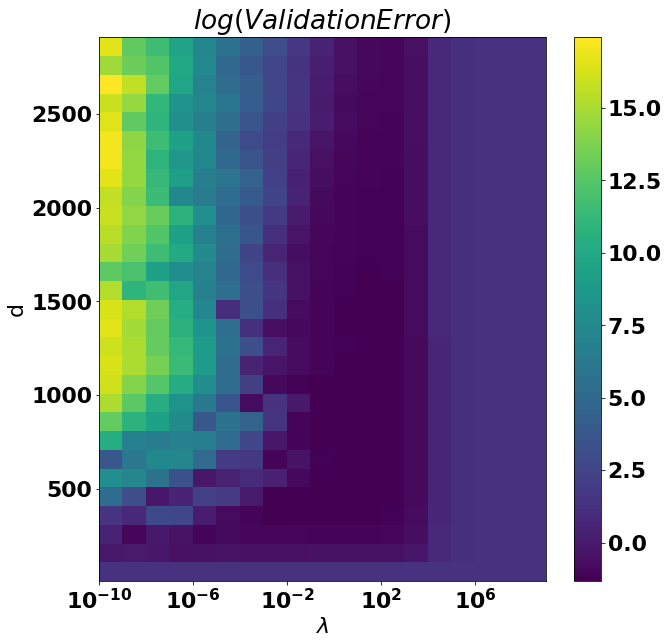

In [231]:
LA,D = np.meshgrid(lambs,ds)
plt.figure(figsize=(10,10))
plt.pcolor(LA,D,np.log(v_error))
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('d')
plt.colorbar()
plt.title('$log(Validation Error)$')
idx_min = np.unravel_index(np.argmin(v_error),v_error.shape)
print("Minimum validation error of {} at (d,lambda) = ({},{})".format(v_error[idx_min],ds[idx_min[0]],lambs[idx_min[1]]))
plt.savefig('ridge_validation.png')

## Train on the full training set

In [232]:
d = ds[idx_min[0]]
lamb = lambs[idx_min[1]]
X_mat = featurize_fourier(x_train, d, L)
weight = solve_ridge(X_mat,y_train,lambda_ridge=lamb)
error = get_error(X_mat,weight,y_train)

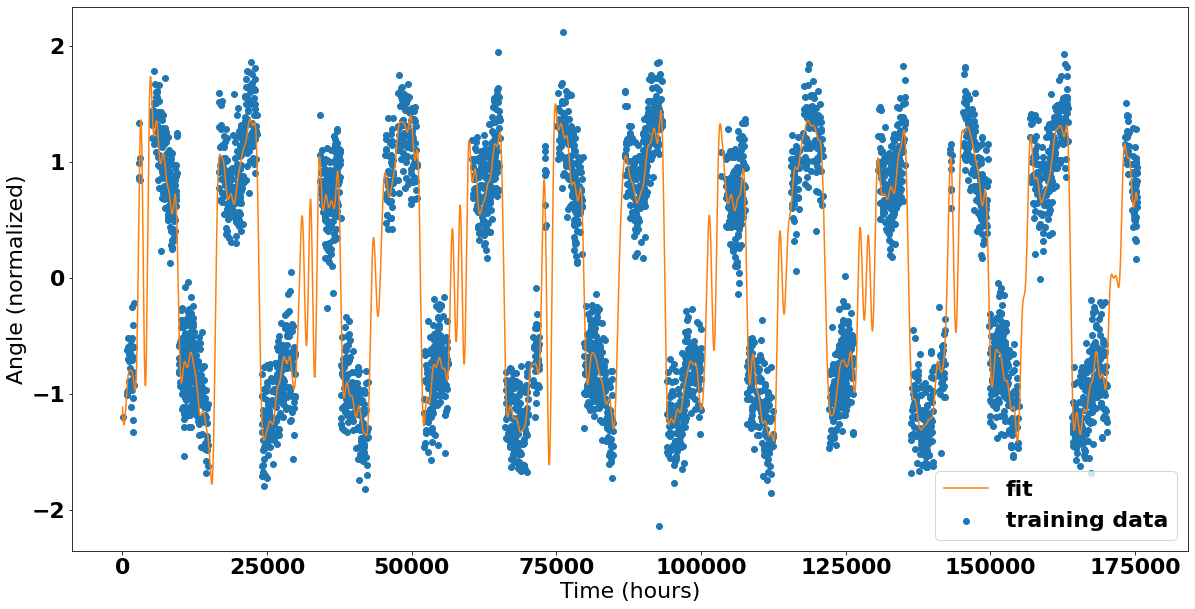

In [275]:
plt.figure(figsize=(20,10))
plt.scatter(x_train,y_train,label='training data')
x_plt = np.linspace(min(x_train),max(x_train),10000)
X_mat_plt = featurize_fourier(x_plt,d,L)
plt.plot(x_plt,X_mat_plt@weight,'C1',label='fit')
plt.xlabel('Time (hours)')
plt.ylabel('Angle (normalized)')
plt.legend()
plt.savefig('2L_fit_ridge.png')

Max Power Period is 584.4466666666666 days
Power-Averaged Period is 582.4980584654705 days


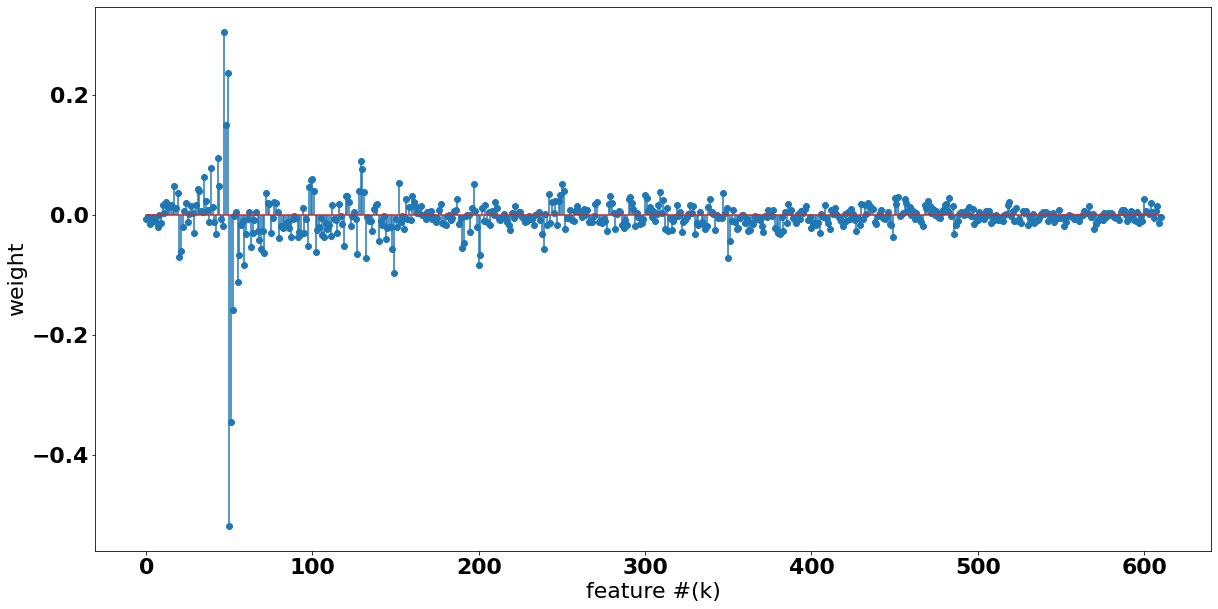

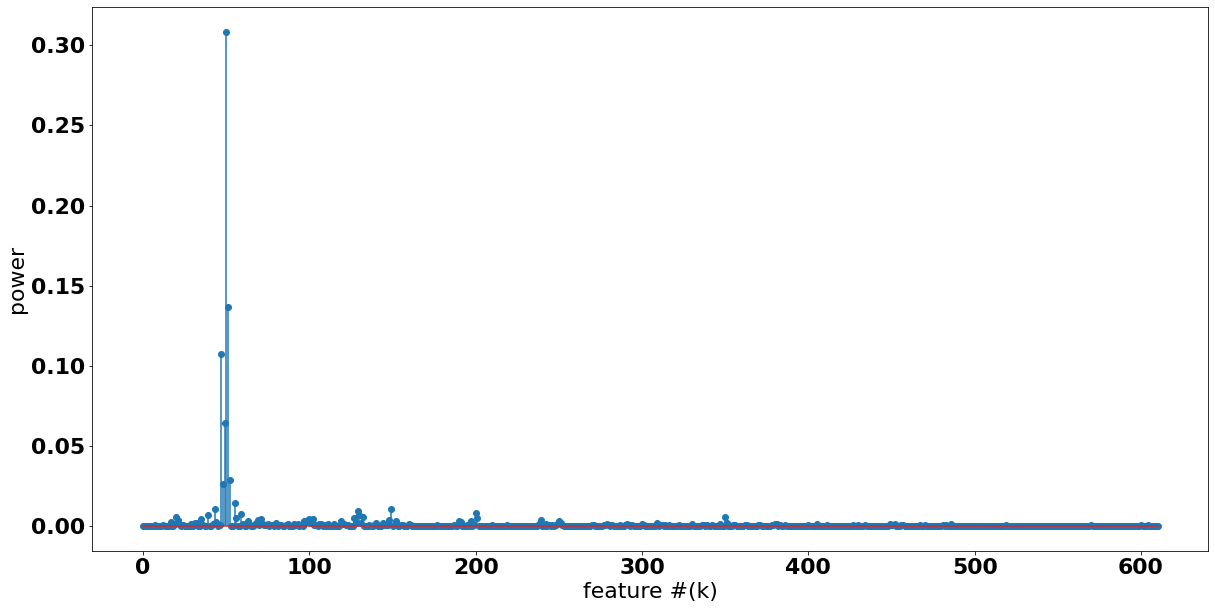

In [282]:
plt.figure(figsize=(20,10))
plot_weights(weight)
plt.savefig('2Lweights_ridge.png')
plt.figure(figsize=(20,10))
plot_power(weight)
print_period(weight,L)
plt.savefig('2Lpower_ridge.png')

## Evaluate Test error of the ridge model and plot

### Get the test set. Set x values w.r.t. time zero from training set

In [76]:
offset = len(time)*2-2
az_test,el_test,time_test,az_good_test,el_good_test,time_good_test,az_good_2_test,el_good_2_test,time_good_2_test,az_n_test,el_n_test,az_good_n_test,el_good_n_test,az_good_2_n_test,el_good_2_n_test = get_venus("BC 480-Oct-14","BC 460-Oct-14", 2,offset=offset)


### Plot the ridge regression model on the test data

1.0092264775685655


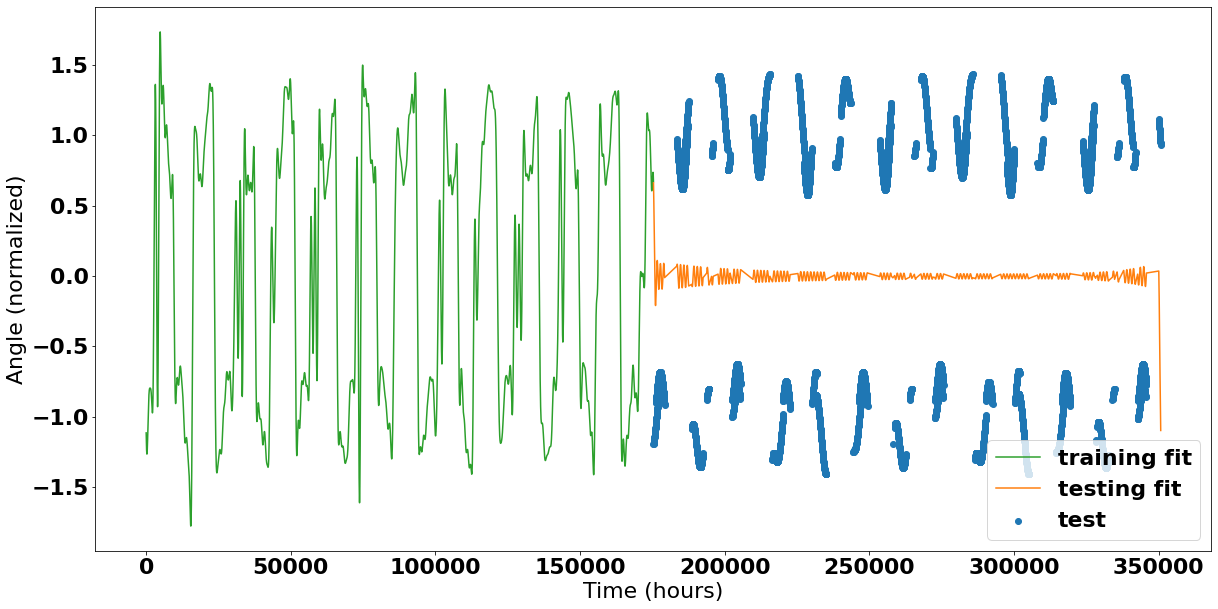

In [271]:
d = ds[idx_min[0]]
plt.figure(figsize=(20,10))
x_test, y_test = gen_data(time_good_2_test,az_good_2_test,0,1,shuffle=False,whiten_flag=True)
plt.scatter(x_test,y_test,label='test')
x_plt_train = np.linspace(min(x_train),max(x_train),10000)
x_plt_test = np.linspace(min(x_test),max(x_test),10000)
X_mat_plt_train = featurize_fourier(x_plt_train,d,L)
X_mat_test = featurize_fourier(x_test,d,L)
plt.plot(x_plt_train,X_mat_plt_train@weight,'C2',label='training fit')
plt.plot(x_test,X_mat_test@weight,'C1',label='testing fit')
print(get_error(X_mat_test,weight,y_test))
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Angle (normalized)')
plt.savefig('2L_extrap_ridge.png')

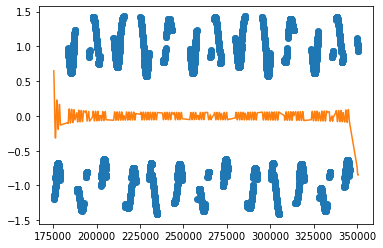

In [78]:
plt.scatter(x_test,y_test)
plt.plot(x_test,X_mat_test@weight,'C1')

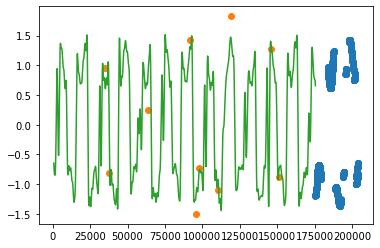

In [79]:
plt.scatter(x_test[0:1000],y_test[0:1000])
plt.scatter(x_train[-10::],y_train[-10::])
plt.plot(x_plt_train[-10000::],(X_mat_plt_train@weight)[-10000::],'C2')

# Try LASSO in $n>d$ regime

In [257]:
# note: keep d from before
x_train, y_train = gen_data(time_good_2, az_good_2,20,0.75)
n_split = 4
kf = KFold(n_split)
ds = np.arange(11,3000,100)
lambs = 10.0**np.arange(-5,5)
# note: at only one L, this model is no good for extrapolating, as f(x) = f(x+L)
L_fact = 2
L = L_fact*(max(x_train)-min(x_train))
v_error_lasso = np.zeros((len(lambs)))
X_mat = featurize_fourier(x_train, d, L)
for j,lamb in enumerate(lambs):
    print(j)
    for train_idx, val_idx in kf.split(X_mat):
        weight_lasso = solve_lasso(X_mat[train_idx],y_train[train_idx],lambda_lasso=lamb)
        v_error_lasso[j] += get_error(X_mat[val_idx],weight_lasso,y_train[val_idx])

0
1
2
3
4
5
6
7
8
9


## Plot the validation error, print the best hyperparameters

Minimum validation error of 0.28660378682483967 at lambda = 0.001


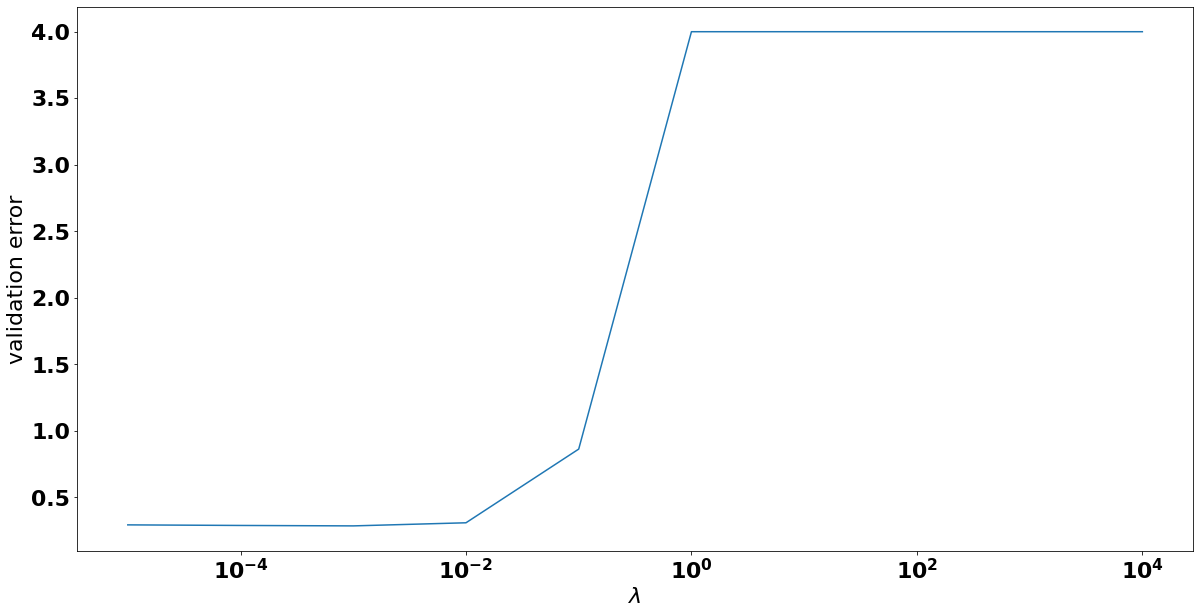

In [280]:
plt.figure(figsize=(20,10))
plt.plot(lambs,v_error_lasso)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('validation error')
plt.savefig('2L_validation_lasso.png')
idx_min_lasso = np.argmin(v_error_lasso)
print("Minimum validation error of {} at lambda = {}".format(v_error_lasso[idx_min_lasso], lambs[idx_min_lasso]))

## Train on the full training set

In [266]:
lamb = lambs[idx_min_lasso]
L_fact = 2
L = L_fact*(max(x_train)-min(x_train))
X_mat = featurize_fourier(x_train, d, L)
weight_lasso = solve_lasso(X_mat,y_train,lambda_lasso=lamb)
error = get_error(X_mat,weight_lasso,y_train)

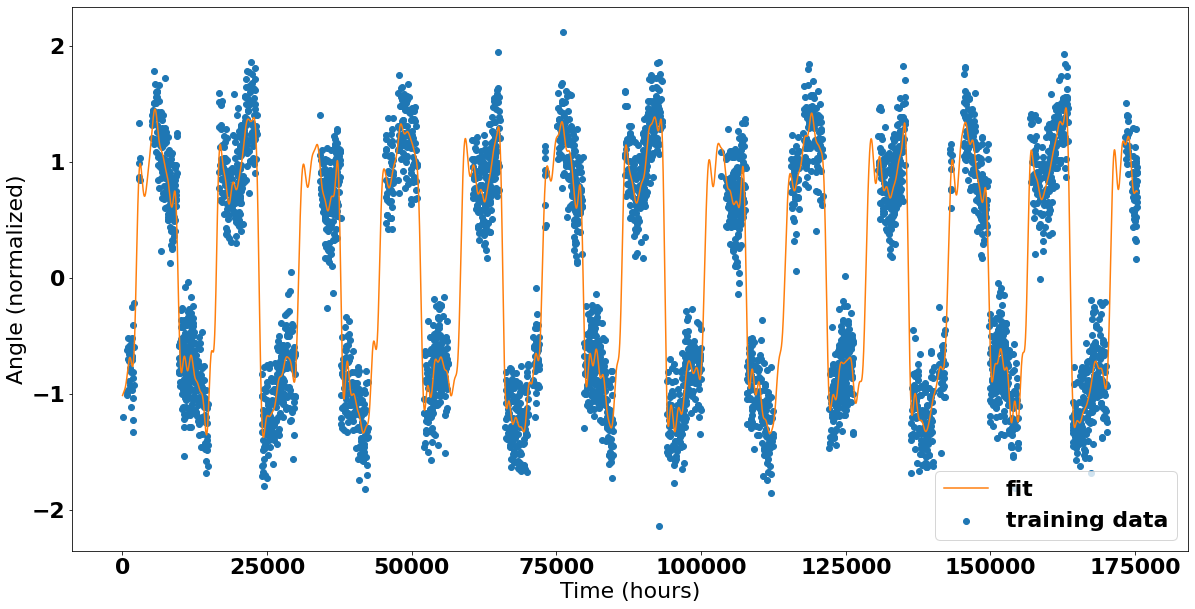

In [274]:
plt.figure(figsize=(20,10))
plt.scatter(x_train,y_train,label='training data')
x_plt = np.linspace(min(x_train),max(x_train),10000)
X_mat_plt = featurize_fourier(x_plt,d,L)
plt.plot(x_plt,X_mat_plt@weight_lasso,'C1',label='fit')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Angle (normalized)')
plt.savefig('2L_fit_lasso.png')

Max Power Period is 584.4466666666666 days
Power-Averaged Period is 584.4415292785295 days


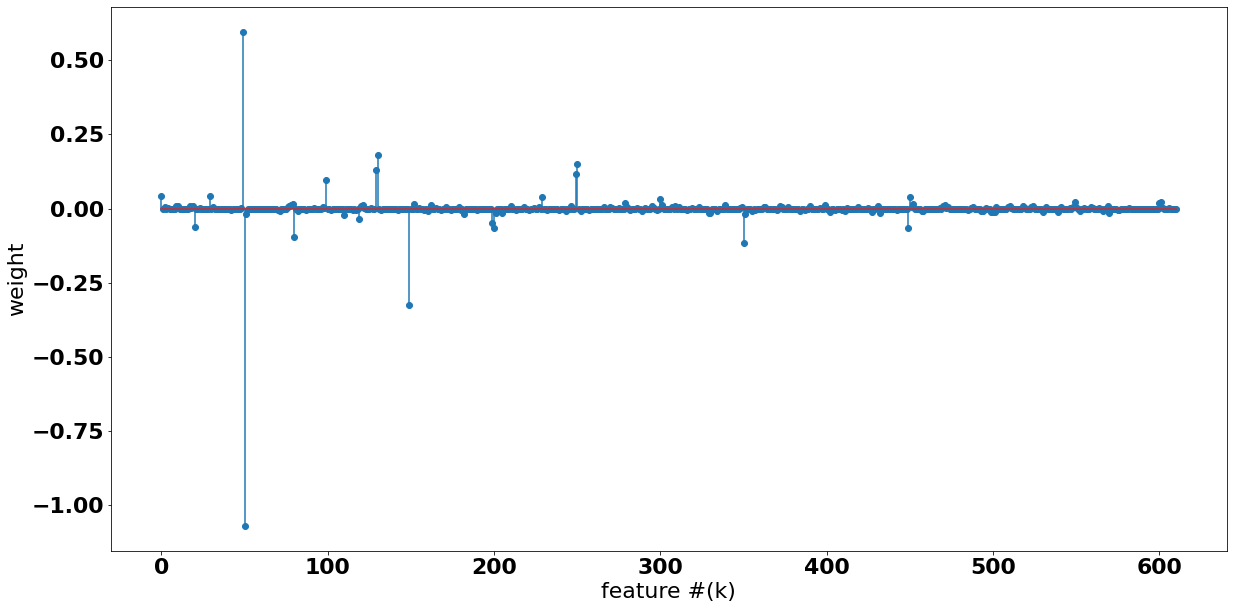

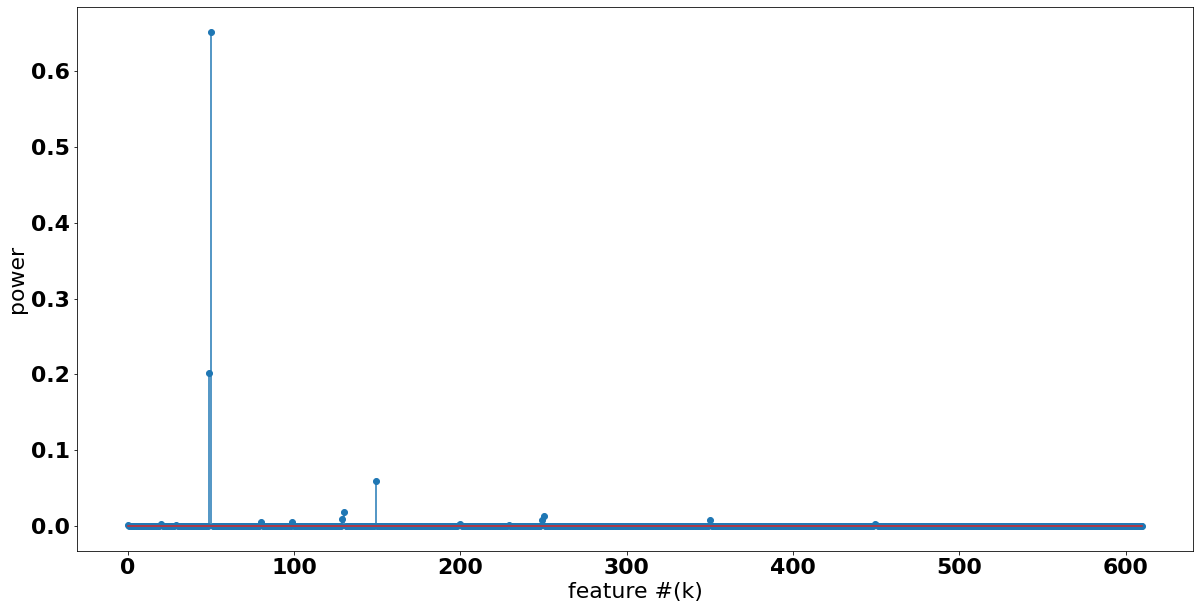

In [283]:
plt.figure(figsize=(20,10))
plot_weights(weight_lasso)
plt.savefig('2L_weight_lasso.png')
plt.figure(figsize=(20,10))
plot_power(weight_lasso)
plt.savefig('2L_power_lasso.png')
print_period(weight_lasso,L)

## Evaluate Test error of the ridge model and plot

### Plot the ridge regression model on the test data

1.9671838897305234


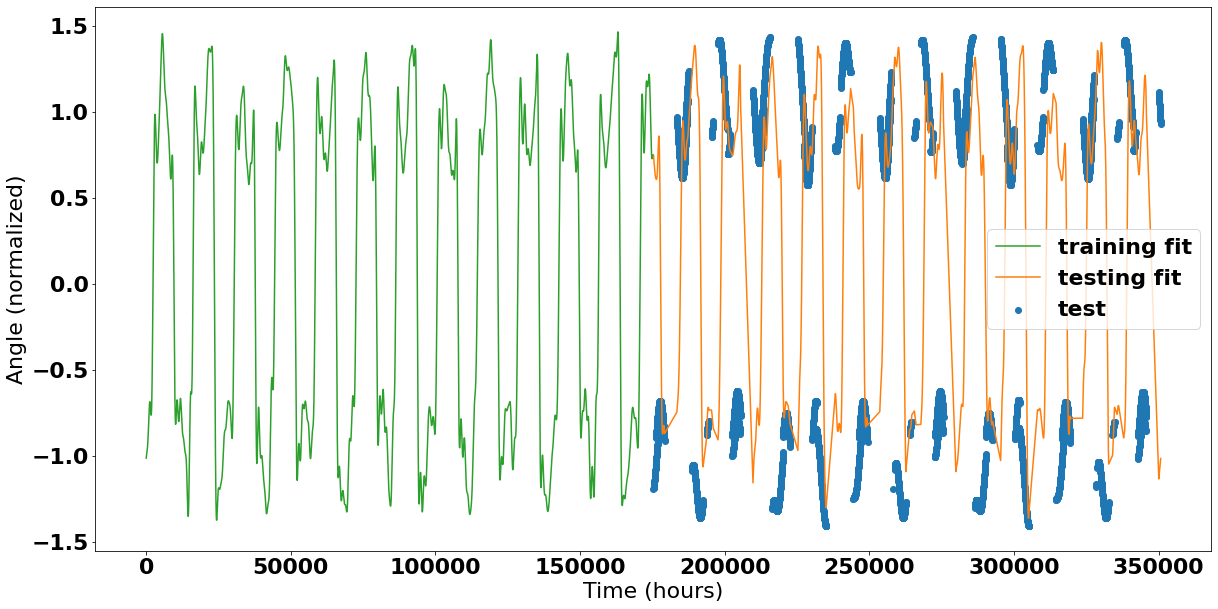

In [278]:
x_test, y_test = gen_data(time_good_2_test,az_good_2_test,0,1,shuffle=False,whiten_flag=True)
plt.figure(figsize=(20,10))
plt.scatter(x_test,y_test,label = 'test')
x_plt_train = np.linspace(min(x_train),max(x_train),10000)
x_plt_test = np.linspace(min(x_test),max(x_test),10000)
X_mat_plt_train = featurize_fourier(x_plt_train,d,L)
X_mat_test = featurize_fourier(x_test,d,L)
plt.plot(x_plt_train,X_mat_plt_train@weight_lasso,'C2',label='training fit')
plt.plot(x_test,X_mat_test@weight_lasso,'C1',label='testing fit')
print(get_error(X_mat_test,weight_lasso,y_test))
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Angle (normalized)')
plt.savefig('2L_extrap_lasso.png')

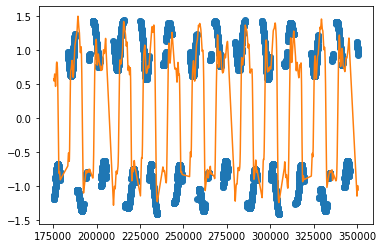

In [222]:
plt.scatter(x_test,y_test)
plt.plot(x_test,X_mat_test@weight_lasso,'C1')

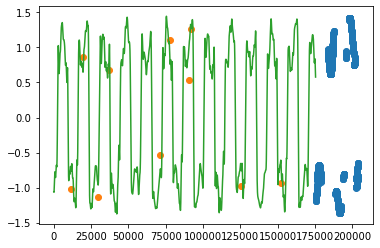

In [223]:
plt.scatter(x_test[0:1000],y_test[0:1000])
plt.scatter(x_train[-10::],y_train[-10::])
plt.plot(x_plt_train[-10000::],(X_mat_plt_train@weight_lasso)[-10000::],'C2')

# Run the above, but with L 10*known period 
# Run Ridge w/ Fourier features in the $d < n$ regime
## Perform 4-fold cross validation on the training set

In [148]:
x_train, y_train = gen_data(time_good_2, az_good_2,20,0.75)
n_split = 4
kf = KFold(n_split)
ds = np.arange(11,3000,100)
lambs = 10.0**np.arange(-10,10)
# note: at only one L, this model is no good for extrapolating, as f(x) = f(x+L)
L = 10*24*583.92
v_error = np.zeros((len(ds),len(lambs)))
for i,d in enumerate(ds):
    X_mat = featurize_fourier(x_train, d, L)
    for j,lamb in enumerate(lambs):
        for train_idx, val_idx in kf.split(X_mat):
            weight = solve_ridge(X_mat[train_idx],y_train[train_idx],lambda_ridge=lamb)
            v_error[i,j] += get_error(X_mat[val_idx],weight,y_train[val_idx])

## Plot the validation error, print the best hyperparameters

Minimum validation error of 0.2572150661264361 at (d,lambda) = (311,10.0)


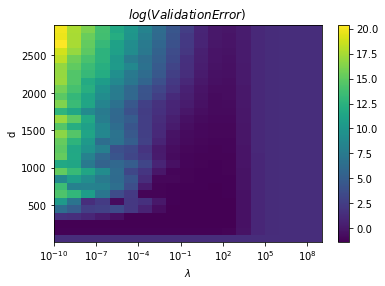

In [149]:
LA,D = np.meshgrid(lambs,ds)
plt.pcolor(LA,D,np.log(v_error))
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('d')
plt.colorbar()
plt.title('$log(Validation Error)$')
idx_min = np.unravel_index(np.argmin(v_error),v_error.shape)
print("Minimum validation error of {} at (d,lambda) = ({},{})".format(v_error[idx_min],ds[idx_min[0]],lambs[idx_min[1]]))

## Train on the full training set

In [150]:
d = ds[idx_min[0]]
lamb = lambs[idx_min[1]]
X_mat = featurize_fourier(x_train, d, L)
weight = solve_ridge(X_mat,y_train,lambda_ridge=lamb)
error = get_error(X_mat,weight,y_train)

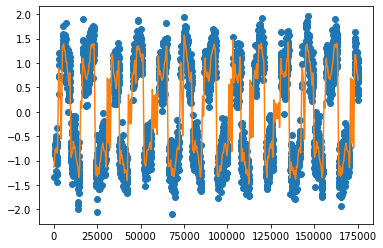

In [151]:
plt.scatter(x_train,y_train)
x_plt = np.linspace(min(x_train),max(x_train),10000)
X_mat_plt = featurize_fourier(x_plt,d,L)
plt.plot(x_plt,X_mat_plt@weight,'C1')

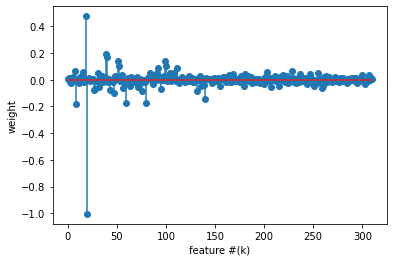

Max Power Period is 583.92 days
Power-Averaged Period is 584.3884146681812 days


In [152]:
plot_weights(weight)
print_period(weight,L)

## Evaluate Test error of the ridge model and plot

### Plot the ridge regression model on the test data

2.0267526031105954


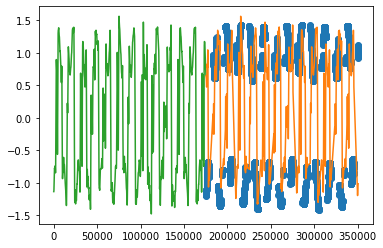

In [153]:
d = ds[idx_min[0]]
x_test, y_test = gen_data(time_good_2_test,az_good_2_test,0,1,shuffle=False,whiten_flag=True)
plt.scatter(x_test,y_test)
x_plt_train = np.linspace(min(x_train),max(x_train),10000)
x_plt_test = np.linspace(min(x_test),max(x_test),10000)
X_mat_plt_train = featurize_fourier(x_plt_train,d,L)
X_mat_test = featurize_fourier(x_test,d,L)
plt.plot(x_plt_train,X_mat_plt_train@weight,'C2')
plt.plot(x_test,X_mat_test@weight,'C1')
print(get_error(X_mat_test,weight,y_test))

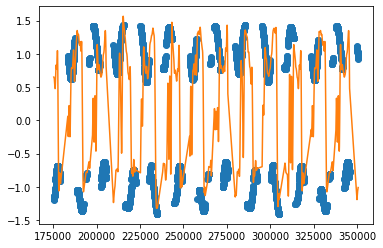

In [154]:
plt.scatter(x_test,y_test)
plt.plot(x_test,X_mat_test@weight,'C1')

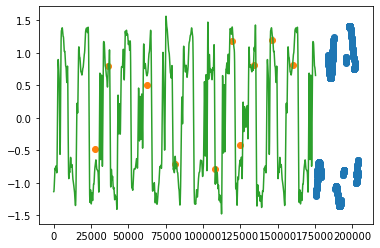

In [155]:
plt.scatter(x_test[0:1000],y_test[0:1000])
plt.scatter(x_train[-10::],y_train[-10::])
plt.plot(x_plt_train[-10000::],(X_mat_plt_train@weight)[-10000::],'C2')

# Try LASSO in $n>d$ regime

In [156]:
# note: keep d from before
x_train, y_train = gen_data(time_good_2, az_good_2,20,0.75)
n_split = 4
kf = KFold(n_split)
L = 10*24*583.92
lambs = 10.0**np.arange(-5,5)
v_error_lasso = np.zeros((len(lambs)))
X_mat = featurize_fourier(x_train, d, L)
for j,lamb in enumerate(lambs):
    print(j)
    for train_idx, val_idx in kf.split(X_mat):
        weight_lasso = solve_lasso(X_mat[train_idx],y_train[train_idx],lambda_lasso=lamb)
        v_error_lasso[j] += get_error(X_mat[val_idx],weight_lasso,y_train[val_idx])

0


C:\Users\class\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.94216603488087, tolerance: 0.35247101170213735
  model = cd_fast.enet_coordinate_descent(
C:\Users\class\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.443358140953933, tolerance: 0.34638760268616264
  model = cd_fast.enet_coordinate_descent(
C:\Users\class\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6626690829913287, tolerance: 0.3537935831662193
  model = cd_fast.enet_coordinate_descent(
C:\Users\class\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceW

1
2
3
4
5
6
7
8
9


## Plot the validation error, print the best hyperparameters

Minimum validation error of 0.3916700180296526 at lambda = 1e-05


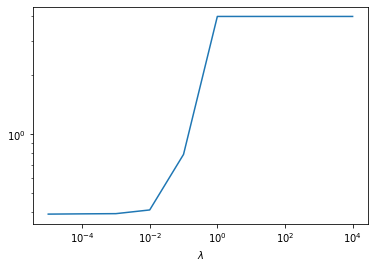

In [157]:
plt.plot(lambs,v_error_lasso)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$')
idx_min = np.argmin(v_error_lasso)
print("Minimum validation error of {} at lambda = {}".format(v_error_lasso[idx_min], lambs[idx_min]))

## Train on the full training set

In [158]:
#lamb = lambs[idx_min]
lamb = 0.01
X_mat = featurize_fourier(x_train, d, L)
weight_lasso = solve_lasso(X_mat,y_train,lambda_lasso=lamb)
error = get_error(X_mat,weight_lasso,y_train)

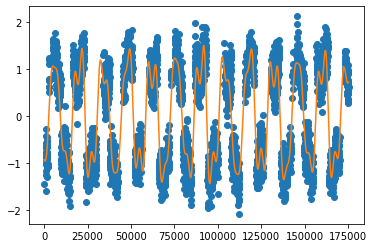

In [159]:
plt.scatter(x_train,y_train)
x_plt = np.linspace(min(x_train),max(x_train),10000)
X_mat_plt = featurize_fourier(x_plt,d,L)
plt.plot(x_plt,X_mat_plt@weight_lasso,'C1')

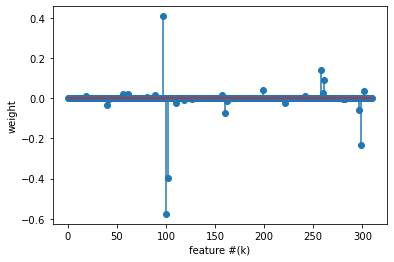

Max Power Period is 583.92 days
Power-Averaged Period is 584.1562967745057 days
100


In [160]:
plot_weights(weight_lasso)
print_period(weight_lasso,L)
print(np.argmin(weight_lasso))

## Evaluate Test error of the ridge model and plot

### Plot the ridge regression model on the test data

1.6735743637797007


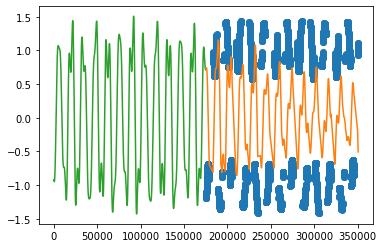

In [161]:
x_test, y_test = gen_data(time_good_2_test,az_good_2_test,0,1,shuffle=False,whiten_flag=True)
plt.scatter(x_test,y_test)
x_plt_train = np.linspace(min(x_train),max(x_train),10000)
x_plt_test = np.linspace(min(x_test),max(x_test),10000)
X_mat_plt_train = featurize_fourier(x_plt_train,d,L)
X_mat_test = featurize_fourier(x_test,d,L)
plt.plot(x_plt_train,X_mat_plt_train@weight_lasso,'C2')
plt.plot(x_test,X_mat_test@weight_lasso,'C1')
print(get_error(X_mat_test,weight_lasso,y_test))

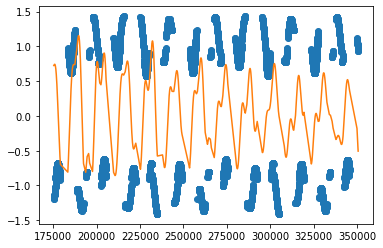

In [162]:
plt.scatter(x_test,y_test)
plt.plot(x_test,X_mat_test@weight_lasso,'C1')

# Run the above, but with L equal to the known period 
# Run Ridge w/ Fourier features in the $d < n$ regime
## Perform 4-fold cross validation on the training set

In [163]:
x_train, y_train = gen_data(time_good_2, az_good_2,20,0.75)
n_split = 4
kf = KFold(n_split)
ds = np.arange(11,3000,100)
lambs = 10.0**np.arange(-10,10)
# note: at only one L, this model is no good for extrapolating, as f(x) = f(x+L)
L = 24*583.92
v_error = np.zeros((len(ds),len(lambs)))
for i,d in enumerate(ds):
    X_mat = featurize_fourier(x_train, d, L)
    for j,lamb in enumerate(lambs):
        for train_idx, val_idx in kf.split(X_mat):
            weight = solve_ridge(X_mat[train_idx],y_train[train_idx],lambda_ridge=lamb)
            v_error[i,j] += get_error(X_mat[val_idx],weight,y_train[val_idx])

C:\Users\class\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.07899e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\class\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.00237e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\class\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.21119e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\class\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.62001e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


## Plot the validation error, print the best hyperparameters

Minimum validation error of 0.4336798838559871 at (d,lambda) = (111,1.0)


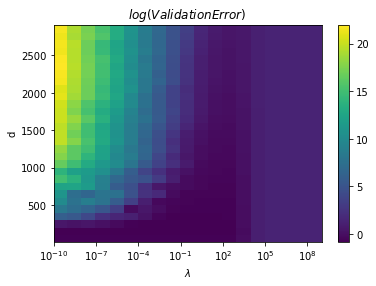

In [164]:
LA,D = np.meshgrid(lambs,ds)
plt.pcolor(LA,D,np.log(v_error))
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('d')
plt.colorbar()
plt.title('$log(Validation Error)$')
idx_min = np.unravel_index(np.argmin(v_error),v_error.shape)
print("Minimum validation error of {} at (d,lambda) = ({},{})".format(v_error[idx_min],ds[idx_min[0]],lambs[idx_min[1]]))

## Train on the full training set

In [165]:
d = ds[idx_min[0]]
lamb = lambs[idx_min[1]]
X_mat = featurize_fourier(x_train, d, L)
weight = solve_ridge(X_mat,y_train,lambda_ridge=lamb)
error = get_error(X_mat,weight,y_train)

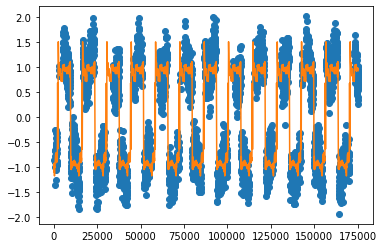

In [166]:
plt.scatter(x_train,y_train)
x_plt = np.linspace(min(x_train),max(x_train),10000)
X_mat_plt = featurize_fourier(x_plt,d,L)
plt.plot(x_plt,X_mat_plt@weight,'C1')

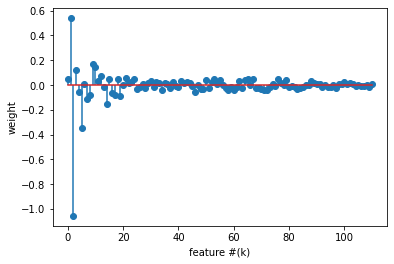

Max Power Period is 583.92 days
Power-Averaged Period is nan days


<ipython-input-84-470d4c893030>:123: RuntimeWarning: divide by zero encountered in true_divide
  power_avg_period = np.sum(w[idx_region]**2 * (L/24/ks))/np.sum(w[idx_region]**2)
C:\Users\class\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [167]:
plot_weights(weight)
print_period(weight,L)

## Evaluate Test error of the ridge model and plot

### Plot the ridge regression model on the test data

1.9760543012477285


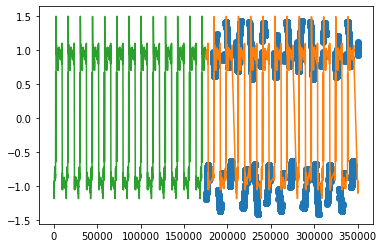

In [168]:
d = ds[idx_min[0]]
x_test, y_test = gen_data(time_good_2_test,az_good_2_test,0,1,shuffle=False,whiten_flag=True)
plt.scatter(x_test,y_test)
x_plt_train = np.linspace(min(x_train),max(x_train),10000)
x_plt_test = np.linspace(min(x_test),max(x_test),10000)
X_mat_plt_train = featurize_fourier(x_plt_train,d,L)
X_mat_test = featurize_fourier(x_test,d,L)
plt.plot(x_plt_train,X_mat_plt_train@weight,'C2')
plt.plot(x_test,X_mat_test@weight,'C1')
print(get_error(X_mat_test,weight,y_test))

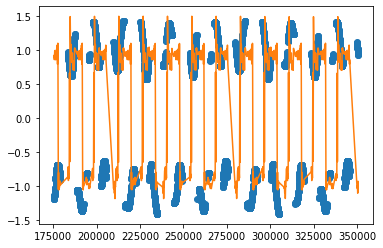

In [169]:
plt.scatter(x_test,y_test)
plt.plot(x_test,X_mat_test@weight,'C1')

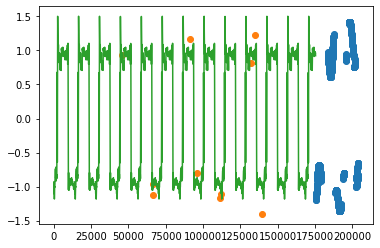

In [170]:
plt.scatter(x_test[0:1000],y_test[0:1000])
plt.scatter(x_train[-10::],y_train[-10::])
plt.plot(x_plt_train[-10000::],(X_mat_plt_train@weight)[-10000::],'C2')

# Try LASSO in $n>d$ regime

In [171]:
# note: keep d from before
x_train, y_train = gen_data(time_good_2, az_good_2,20,0.75)
n_split = 4
kf = KFold(n_split)
L = 24*583.92
lambs = 10.0**np.arange(-5,5)
v_error_lasso = np.zeros((len(lambs)))
X_mat = featurize_fourier(x_train, d, L)
for j,lamb in enumerate(lambs):
    print(j)
    for train_idx, val_idx in kf.split(X_mat):
        weight_lasso = solve_lasso(X_mat[train_idx],y_train[train_idx],lambda_lasso=lamb)
        v_error_lasso[j] += get_error(X_mat[val_idx],weight_lasso,y_train[val_idx])

0
1
2
3
4
5
6
7
8
9


## Plot the validation error, print the best hyperparameters

Minimum validation error of 0.4488292572883846 at lambda = 0.001


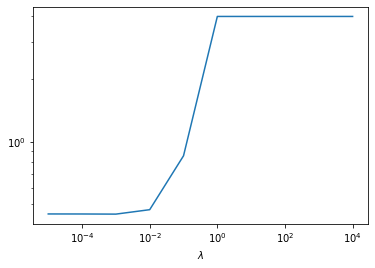

In [172]:
plt.plot(lambs,v_error_lasso)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$')
idx_min = np.argmin(v_error_lasso)
print("Minimum validation error of {} at lambda = {}".format(v_error_lasso[idx_min], lambs[idx_min]))

## Train on the full training set

In [173]:
#lamb = lambs[idx_min]
lamb = 0.01
X_mat = featurize_fourier(x_train, d, L)
weight_lasso = solve_lasso(X_mat,y_train,lambda_lasso=lamb)
error = get_error(X_mat,weight_lasso,y_train)

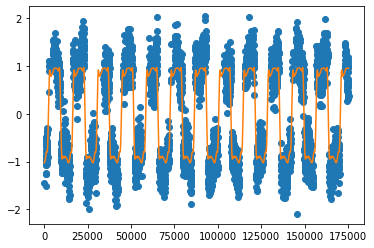

In [174]:
plt.scatter(x_train,y_train)
x_plt = np.linspace(min(x_train),max(x_train),10000)
X_mat_plt = featurize_fourier(x_plt,d,L)
plt.plot(x_plt,X_mat_plt@weight_lasso,'C1')

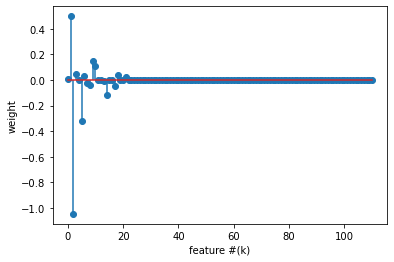

Max Power Period is 583.92 days
Power-Averaged Period is nan days
2


<ipython-input-84-470d4c893030>:123: RuntimeWarning: divide by zero encountered in true_divide
  power_avg_period = np.sum(w[idx_region]**2 * (L/24/ks))/np.sum(w[idx_region]**2)
<ipython-input-84-470d4c893030>:123: RuntimeWarning: invalid value encountered in multiply
  power_avg_period = np.sum(w[idx_region]**2 * (L/24/ks))/np.sum(w[idx_region]**2)


In [175]:
plot_weights(weight_lasso)
print_period(weight_lasso,L)
print(np.argmin(weight_lasso))

## Evaluate Test error of the ridge model and plot

### Plot the ridge regression model on the test data

1.8910440578301648


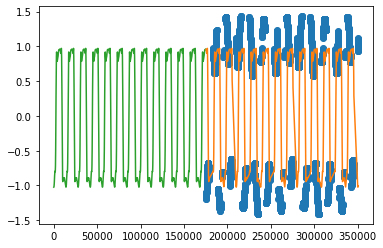

In [176]:
x_test, y_test = gen_data(time_good_2_test,az_good_2_test,0,1,shuffle=False,whiten_flag=True)
plt.scatter(x_test,y_test)
x_plt_train = np.linspace(min(x_train),max(x_train),10000)
x_plt_test = np.linspace(min(x_test),max(x_test),10000)
X_mat_plt_train = featurize_fourier(x_plt_train,d,L)
X_mat_test = featurize_fourier(x_test,d,L)
plt.plot(x_plt_train,X_mat_plt_train@weight_lasso,'C2')
plt.plot(x_test,X_mat_test@weight_lasso,'C1')
print(get_error(X_mat_test,weight_lasso,y_test))

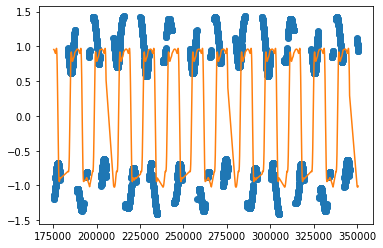

In [177]:
plt.scatter(x_test,y_test)
plt.plot(x_test,X_mat_test@weight_lasso,'C1')

# Run Min-norm w/ Fourier features in the $n < d$ regime
## Perform 4-fold cross validation on the training set

In [294]:
x_train_spike, y_train_spike = gen_data(time_good_2, az_good_2,20,0.1)
n_split = 4
kf = KFold(n_split)
dfs = np.arange(1,102,50)
sfs = np.arange(0.1,1.1,0.2)
gammas = np.arange(0,1.1,0.1)
L = max(x_train)-min(x_train)
v_error_spiked = np.zeros((len(ds),len(ss),len(gammas)))
for i,df in enumerate(dfs):
    print(i)
    for j,sf in enumerate(sfs):
        for k,gamma in enumerate(gammas):
            print('i,j,k = {},{},{}'.format(i,j,k))
            d = df*len(x_train_spike)
            d += 1-d%2
            s = (sf*len(x_train_spike)).astype(int)
            X_mat = featurize_fourier_spiked(x_train_spike, d, L, s, gamma)
            for train_idx, val_idx in kf.split(X_mat):
                weight = solve_ls(X_mat[train_idx],y_train_spike[train_idx])
                v_error_spiked[i,j,k] += get_error(X_mat[val_idx],weight,y_train_spike[val_idx])

0
i,j,k = 0,0,0
i,j,k = 0,0,1
i,j,k = 0,0,2
i,j,k = 0,0,3
i,j,k = 0,0,4
i,j,k = 0,0,5
i,j,k = 0,0,6
i,j,k = 0,0,7
i,j,k = 0,0,8
i,j,k = 0,0,9
i,j,k = 0,0,10
i,j,k = 0,1,0
i,j,k = 0,1,1
i,j,k = 0,1,2
i,j,k = 0,1,3
i,j,k = 0,1,4
i,j,k = 0,1,5
i,j,k = 0,1,6
i,j,k = 0,1,7
i,j,k = 0,1,8
i,j,k = 0,1,9
i,j,k = 0,1,10
i,j,k = 0,2,0
i,j,k = 0,2,1
i,j,k = 0,2,2
i,j,k = 0,2,3
i,j,k = 0,2,4
i,j,k = 0,2,5
i,j,k = 0,2,6
i,j,k = 0,2,7
i,j,k = 0,2,8
i,j,k = 0,2,9
i,j,k = 0,2,10
i,j,k = 0,3,0
i,j,k = 0,3,1
i,j,k = 0,3,2
i,j,k = 0,3,3
i,j,k = 0,3,4
i,j,k = 0,3,5
i,j,k = 0,3,6
i,j,k = 0,3,7
i,j,k = 0,3,8
i,j,k = 0,3,9
i,j,k = 0,3,10
i,j,k = 0,4,0
i,j,k = 0,4,1
i,j,k = 0,4,2
i,j,k = 0,4,3
i,j,k = 0,4,4
i,j,k = 0,4,5
i,j,k = 0,4,6
i,j,k = 0,4,7
i,j,k = 0,4,8
i,j,k = 0,4,9
i,j,k = 0,4,10
1
i,j,k = 1,0,0
i,j,k = 1,0,1
i,j,k = 1,0,2
i,j,k = 1,0,3
i,j,k = 1,0,4
i,j,k = 1,0,5
i,j,k = 1,0,6
i,j,k = 1,0,7
i,j,k = 1,0,8
i,j,k = 1,0,9
i,j,k = 1,0,10
i,j,k = 1,1,0
i,j,k = 1,1,1
i,j,k = 1,1,2
i,j,k = 1,1,3
i,j,k = 1,

KeyboardInterrupt: 

In [189]:
idx_min = np.unravel_index(np.argmin(v_error_spiked),v_error_spiked.shape)
print("Minimum validation error of {} at (d,s,gamma) = ({},{},{})".format(
    v_error_spiked[idx_min],ds[idx_min[0]],ss[idx_min[1]],gammas[idx_min[2]]))

Minimum validation error of 1.1596521389570487 at (d,s,gamma) = (481973,477,0.9)
[  4773 243373 481973]


64236

In [ ]:
d = ds[idx_min[0]]*len(x_train_spike)
d += 1-d%2
s = (ss[idx_min[1]]*len(x_train_spike)).astype(int)
gamma = gammas[idx_min[2]]
X_mat = featurize_fourier_spiked(x_train_spike, d, L, s, gamma)
weight_spiked = solve_ls(X_mat,y_train_spike)
error = get_error(X_mat,weight_spiked,y_train_spike)

In [ ]:
plt.scatter(x_train_spike,y_train_spike)
x_plt = np.linspace(min(x_train_spike),max(x_train_spike),10000)
X_mat_plt = featurize_fourier_spike(x_plt,d,L,s,gamma)
plt.plot(x_plt,X_mat_plt@weight,'C1')


In [ ]:
plot_weights(weight)
print_period(weight,L)